In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy
import h5py
import glob
import pdb
import itertools
from tqdm import tqdm
from scipy import io 
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from scipy.ndimage import convolve1d, gaussian_filter1d
from scipy.interpolate import interp1d
import sys
sys.path.append('../..')
from loaders import split_shenoy, load_shenoy

In [5]:
from pyuoi.linear_model.var import VAR
from decoders import standardize, lr_decoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from neurosim.models.var import form_companion

In [17]:
# Split the shenoy dataset by trialtype and trialVersion
split_shenoy('/mnt/Secondary/data/shenoy/RC,2009-09-18,1-2,good-ss.mat', '/mnt/Secondary/data/shenoy_split')

268 Bad Trials being thrown away
2
18
16
21
19
21
24
21
22
18
17
19
22
19
21
23
19
15
18
20
20
20
27
24
24
19
22
20
21
20
19
17
23
20
20
22
23
18
20
18
18
22
22
22
20
20
26
18
28
19
17
22
20
20
23
22
24
19
21
18
19
20
19
21
22
22
19
20
20
20
20
23
22
20
24
17
23
26
19
19
20
23
22
18
20
18
19
16
18
19
20
20
18
18
23
25
22
18
20
23
19
21
18
17
20
17
17
22
24
19
16
16
17
19
18
17
23
20


In [18]:
data_files_all = glob.glob('/mnt/Secondary/data/shenoy_split/*.dat')

In [19]:
len(data_files_all)

118

In [40]:
dat = load_shenoy('/mnt/Secondary/data/shenoy/RC,2009-09-18,1-2,good-ss.mat', 
                    bin_width=1, boxcox=0.5,
                    filter_fn='gaussian', filter_kwargs={'sigma':20},
                    tw=(-250, 550), spike_threshold=None, trialVersions=0, trialTypes=[1, 2, 3])


268 Bad Trials being thrown away
66 Trials selected


../../loaders.py:247: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dat['spike_times'] = np.array(spike_times).astype(np.object)


Processing spikes


100%|██████████| 66/66 [00:16<00:00,  4.03it/s]


In [38]:
dat['spike_rates'].shape

(805, 799, 202)

In [24]:
# Sweep over bin_sizes, filtering parameters, lag, decodingwindow

bin_widths = [1, 2, 4]
filters = [('none', {})]
filters.extend([('gaussian', {'sigma':sigma}) for sigma in [20]])

tw = [(-450, 450), (-250, 550)]
spike_threshold =[None, 1, 5]


loader_params = list(itertools.product(bin_widths, filters, tw, spike_threshold))

lags = np.linspace(0, 100, 5).astype(int)
decoding_windows = [1, 3]
behavioral_filter = [('none', {}), ('gaussian', {'sigma':20})]

decoding_params = list(itertools.product(lags, decoding_windows, behavioral_filter))
n_cv = 5

results_list = []

# Try aggregating all files together first
for i, loader_param in tqdm(enumerate(loader_params)):

    dat = load_shenoy('/mnt/Secondary/data/shenoy/RC,2009-09-18,1-2,good-ss.mat', 
                      bin_width=loader_param[0], boxcox=0.5,
                      filter_fn=loader_param[1][0], filter_kwargs=loader_param[1][1],
                      tw=loader_param[2], spike_threshold=loader_param[3])

    cv = KFold(n_cv, shuffle=False)
    fold_idx = 0
        
    for train_idxs, test_idxs in cv.split(dat['spike_rates']):
        for j, decoding_param in enumerate(decoding_params):
            xtrain = dat['spike_rates'][train_idxs]
            xtest = dat['spike_rates'][test_idxs]
            
            # Add axis at the end since position is 1D
            ztrain = dat['behavior'][train_idxs]
            ztest = dat['behavior'][test_idxs]
            
            pdb.set_trace()
            
            lr_r2_, _, _, _ = lr_decoder(xtest, xtrain, ztest, ztrain, 
                                decoding_param[0], decoding_param[0],
                                decoding_param[1])
            result = {}
            result['data_file'] = data_file
            result['bin_width'] = loader_param[0]
            result['filter'] = loader_param[1][0]
            result['filter_kwarg'] = loader_param[1][1]
            result['fold_idx']= fold_idx
            result['lag'] = decoding_param[0]
            result['decoding_window'] = decoding_param[1]
            result['r2'] = lr_r2_
            results_list.append(result)
        fold_idx += 1



0it [00:00, ?it/s]

268 Bad Trials being thrown away


0it [07:08, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Level of aggregation
# Smooth behavior

In [20]:
decoding_results = pd.DataFrame(results_list)

In [21]:
np.max(decoding_results['r2'].values)

0.4887040720592159

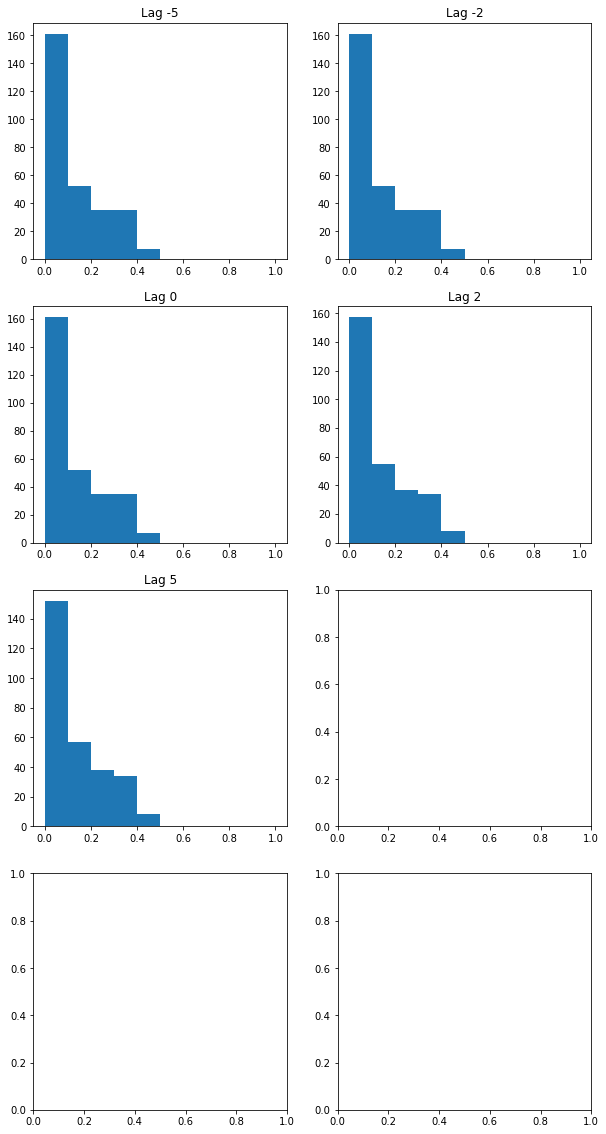

In [22]:
fig, ax = plt.subplots(4, 2, figsize=(10, 20))
for i in range(len(lags)):
    df_ = decoding_results.loc[decoding_results['lag'] == lags[i]]
    a = ax[np.unravel_index(i, (4, 2))]
    a.hist(df_['r2'].values, range=(0, 1))
    a.set_title('Lag %d' % lags[i])

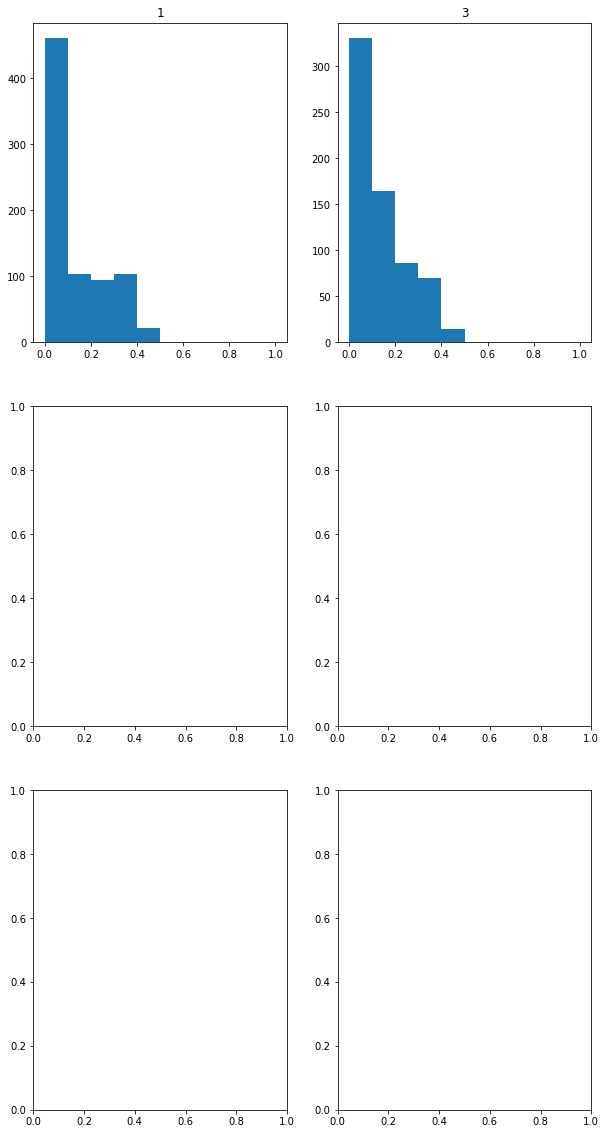

In [25]:
# r2 as a function of decoding window
fig, ax = plt.subplots(3, 2, figsize=(10, 20))
for i in range(len(decoding_windows)):
    df_ = decoding_results.loc[decoding_results['decoding_window'] == decoding_windows[i]]
    a = ax[np.unravel_index(i, (3, 2))]
    a.hist(df_['r2'].values, range=(0, 1))
    a.set_title(decoding_windows[i])